# 1. 构建模型

In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np


# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob, output_size):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, _x):

        out, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        b, h = out.shape  # x is output, size (seq_len, batch, hidden_size)
        out = self.fc(out)

        return out


    def get_data(self, path):

        global sequence_len, batch_size, input_size, ori_y_min, ori_y_max, scaler

        dataset = pd.read_csv(
            path,
            engine="python",
            parse_dates=["timestamp"],
            index_col=["timestamp"],
            encoding="utf-8",
        )
        sequence_len = len(dataset) - 1
        columns = ["open", "high", "low", "close", "volume"]
        for col in columns:

            if col == 'close':
                ori_y_min = pd.DataFrame.min(dataset[col])
                ori_y_max = pd.DataFrame.max(dataset[col])


            scaler = MinMaxScaler()
            dataset[col] = scaler.fit_transform(dataset[col].values.reshape(-1, 1))
        X = dataset.drop(columns=["close"], axis=1)
        y = dataset["close"]

        X = torch.from_numpy(X.values).float()
        y = torch.from_numpy(y.values).float()

        return X, y


D:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2. 初始化模型

## 2.1 设置基本参数

In [2]:
# 设置模型参数
input_size = 4
output_size = 1
sequence_len = 0

hidden_size = 150
# batch_size = 50
num_layers = 1
dropout_prob = 0.2
tot_epoch = 2000
learning_rate = 0.003
l2_reg = 0.0
teacher_len = 50

# 设置训练，测试集
train_ratio = 0.8

# 创建模型实例并将其移动到GPU上
model = LSTMModel(input_size, hidden_size, num_layers, dropout_prob, output_size)
device = torch.device("cuda")
model.to(device)

LSTMModel(
  (lstm): LSTM(4, 150, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=150, out_features=1, bias=True)
)

## 2.2 设置优化器和损失函数

In [3]:
# 定义损失函数和优化器
criterion = nn.MSELoss()  # 调用MSE损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)  # 调用Adam反向传播，梯度下降算法求解器

## 2.3 scaler逆操作

In [4]:
def inverse_min_max_scale(scaled_tensor, min_val, max_val):
    # 逆操作：将缩放后的张量还原为原始范围
    original_tensor = scaled_tensor * (max_val - min_val) + min_val
    return original_tensor

# 3. 获取数据

In [5]:
name = "Floki"
path = "data/" + name + ".csv"

ori_y_min = 0
ori_y_max = 0
scaler = None

input_data, target_data = model.get_data(path)

test_len = int(sequence_len * (train_ratio)) - teacher_len
test_input = input_data[test_len:]
test_target = target_data[test_len:]

input_data = input_data[:test_len + teacher_len].to(device)
target_data = target_data[:test_len + teacher_len].to(device)
target_data = target_data.view(-1, 1)

test_target = test_target.to(device)
test_target = test_target.view(-1, 1)
test_input = test_input.to(device)

# 4. 训练模型

In [6]:
prev_loss = 20000
output = None

epoch = 0
loss = 0
while True:

    if epoch == 1999:
        break

    if epoch < tot_epoch:
        output = model(input_data).to(device)
        loss = criterion(output, target_data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch += 1

        if loss < prev_loss:
            # torch.save(LSTMModel.state_dict(), 'lstm_model.pt')  # save model parameters to files
            prev_loss = loss

        if loss.item() < 1e-4:
            print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch + 1, tot_epoch, loss.item()))
            print("The loss value is reached")
            break
        elif (epoch + 1) % 100 == 0:
            print('Epoch: [{}/{}], Loss:{:.5f}'.format(epoch + 1, tot_epoch, loss.item()))
    else:
        if loss < 0.6:
            break
        else:
            tot_epoch += 500
            continue


Epoch: [100/2000], Loss:0.00070
Epoch: [200/2000], Loss:0.00044
Epoch: [300/2000], Loss:0.00029
Epoch: [400/2000], Loss:0.00019
Epoch: [500/2000], Loss:0.00014
Epoch: [600/2000], Loss:0.00012
Epoch: [700/2000], Loss:0.00011
Epoch [736/2000], Loss: 0.00010
The loss value is reached


In [7]:
def mape(y_true, y_pred):
    absolute_percentage_errors = torch.abs((y_true - y_pred) / y_true)
    mape = torch.mean(absolute_percentage_errors) * 100
    return mape

target_data = inverse_min_max_scale(target_data, ori_y_min, ori_y_max)
output = inverse_min_max_scale(output, ori_y_min, ori_y_max)

mape_value = mape(target_data, output)
print("MAPE (平均绝对百分比误差):", mape_value.item(), "%")


MAPE (平均绝对百分比误差): 3.2469708919525146 %


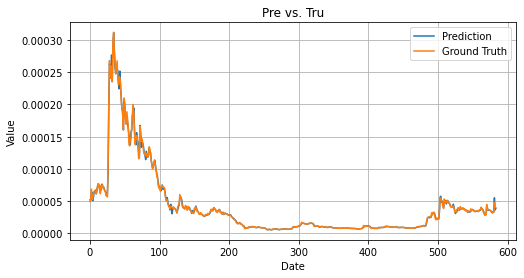

In [8]:
import matplotlib.pyplot as plt

# 示例的预测值和真实值
predictions = output.view(-1).tolist()
ground_truth = target_data.view(-1).tolist()

# 创建 x 轴坐标，可以是简单的范围
x = range(len(predictions))

# 使用Matplotlib绘制折线图
plt.figure(figsize=(8, 4))  # 设置图像大小

# 绘制预测值的折线
plt.plot(predictions, label='Prediction')

# 绘制真实值的折线
plt.plot(ground_truth, label='Ground Truth')

# 添加图例
plt.legend()

# 添加标签
plt.xlabel('Date')
plt.ylabel('Value')

# 显示网格
plt.grid(True)

# 显示图像
plt.title('Pre vs. Tru')
plt.show()


# 5. 预测

In [9]:
# 使用模型进行预测
model.eval()
with torch.no_grad():
    prediction = model(test_input)

test_target = inverse_min_max_scale(test_target, ori_y_min, ori_y_max)
prediction = inverse_min_max_scale(prediction, ori_y_min, ori_y_max)

y_pre = prediction.view(-1).tolist()
y_tru = test_target.view(-1).tolist()

# 6. 评估模型

### 6.1 R^2

In [10]:
def r2_score(y_true, y_pred):
    ssr = torch.sum((y_true - y_pred)**2)
    sst = torch.sum((y_true - torch.mean(y_true))**2)
    r2 = 1 - (ssr / sst)
    return r2

r_squared = r2_score(test_target[teacher_len:], prediction[teacher_len:])
print("R² (决定系数):", r_squared.item())


R² (决定系数): 0.9850183129310608


### 6.2 MAPE

In [11]:
def mape(y_true, y_pred):
    absolute_percentage_errors = torch.abs((y_true - y_pred) / y_true)
    mape = torch.mean(absolute_percentage_errors) * 100
    return mape

mape_value = mape(test_target[teacher_len:], prediction[teacher_len:])
print("MAPE (平均绝对百分比误差):", mape_value.item(), "%")


MAPE (平均绝对百分比误差): 1.9770880937576294 %


### 6.3 绘制图像

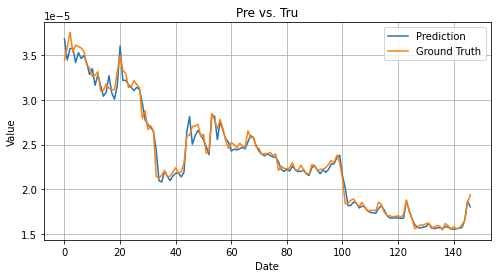

In [12]:
import matplotlib.pyplot as plt

# 示例的预测值和真实值
predictions = y_pre[teacher_len:]
ground_truth = y_tru[teacher_len:]

# 创建 x 轴坐标，可以是简单的范围
x = range(len(predictions))

# 使用Matplotlib绘制折线图
plt.figure(figsize=(8, 4))  # 设置图像大小

# 绘制预测值的折线
plt.plot(predictions, label='Prediction')

# 绘制真实值的折线
plt.plot(ground_truth, label='Ground Truth')

# 添加图例
plt.legend()

# 添加标签
plt.xlabel('Date')
plt.ylabel('Value')

# 显示网格
plt.grid(True)

# 显示图像
plt.title('Pre vs. Tru')
plt.show()


### 6.4 输出预测值和真实值

In [13]:
import pandas as pd

res = pd.DataFrame({"Pre": predictions, "Truth": ground_truth})

res

,Pre,Truth
0,0.000037,0.000034
1,0.000034,0.000036
2,0.000036,0.000038
3,0.000036,0.000035
4,0.000034,0.000036
...,...,...
142,0.000016,0.000016
143,0.000016,0.000016
144,0.000017,0.000016
145,0.000019,0.000019
